In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from os import path, listdir
from glob import glob
from pathlib import Path
import shutil
import random

import keras
from keras import backend as K

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import utils
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#load data
from tensorflow.keras.utils import to_categorical, Sequence, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

#base layers
from tensorflow.keras.layers import Input, Resizing, Normalization, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Activation, Dropout

#augmentations
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomCrop, RandomContrast, RandomZoom

from tensorflow.keras.callbacks import History
from tensorflow.data.experimental import AUTOTUNE
autotune = AUTOTUNE

In [2]:
dir_data = '/kaggle/input/severstal-steel-defect-detectionl'
dir_data_new = '/kaggle/input/class-distribution'
path_data = Path(dir_data)
path_data_new = Path(dir_data_new)

data_csv = pd.read_csv(f'{dir_data}/train.csv')
data_train = pd.DataFrame(data_csv)

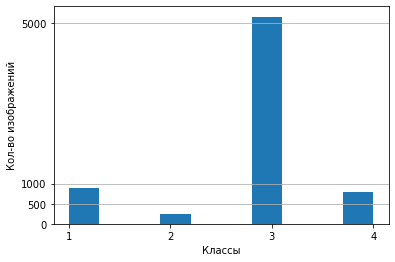

In [3]:
data_train['ClassId'].plot.hist()
plt.xticks(ticks=[1, 2, 3, 4])
plt.yticks(ticks=[0, 500, 1000, 5000])
plt.xlabel('Классы')
plt.ylabel('Кол-во изображений')
plt.grid(axis='y')

In [4]:
#RLE decode/encode

def rle_decode(rle_code, shape):
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    temp = np.int32(rle_code.split(' ')).reshape(-1,2)
    
    for pixel in range(temp.shape[0]):
        for nb_pixel in range(temp[pixel, 0] - 1, temp[pixel, 0] + temp[pixel, 1] - 1):
            img[pixel, nb_pixel] = 255

    img.resize((shape[1], shape[0]))
    img = np.transpose(img)
    
    return img

def rle_invert(rle_code, shape):
    img = np.ones(shape[0] * shape[1], dtype=np.uint8)
    temp = np.int32(rle_code.split(' ')).reshape(-1,2)
    
    for pixel in range(temp.shape[0]):
        for nb_pixel in range(temp[pixel, 0] - 1, temp[pixel, 0] + temp[pixel, 1] - 1):
            img[pixel, nb_pixel] = 0

    img.resize((shape[1], shape[0]))
    img = np.transpose(img)
    img = img * 255
    
    return img

def rle_encode(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = np.transpose(img)
    img = np.resize(img, img.shape[0] * img.shape[1])
    img.dtype = np.uint8
    
    rle_code = ''
    nb_pixel = 0
    pixel = 0
    
    for pix in range(img.shape[0]):
        if (img[pix] == 255):
            if (nb_pixel == 0):
                pixel = pix
            
            nb_pixel += 1
            
            if (pix == img.shape[0] - 1):
                rle_code += (str(pixel) + ' ')
                rle_code += (str(nb_pixel))
        
        elif (img[pix] == 0):
            if (nb_pixel != 0):
                rle_code += (str(pixel) + ' ')
                rle_code += (str(nb_pixel) + ' ')
                nb_pixel = 0
    
    return rle_code

In [5]:
def show_image(path, figsize=(16, 3)):
    image = cv2.imread(path)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.imshow(image)
    
    plt.show()

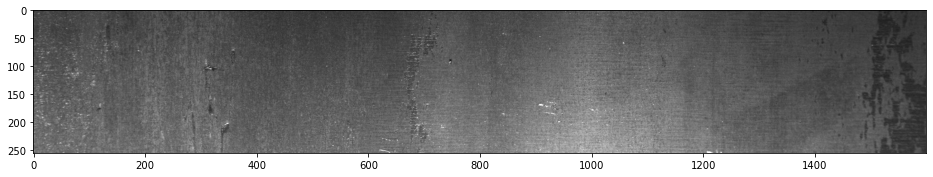

In [6]:
#пример изображений

show_image(f'{dir_data_new}/train_images_to_classes/class_1/0002cc93b.jpg')

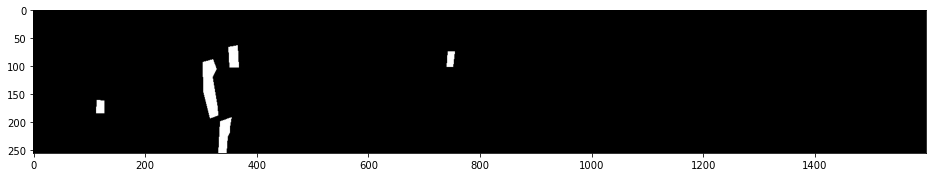

In [7]:
#пример масок

show_image(f'{dir_data_new}/mask_images/class_1/0002cc93b.jpg')

## Создание необходимых метрик и функций потерь

In [8]:
#for MLC

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

## Создание обучающих и тестовых выборок

## Параметры моделей

In [9]:
image_size = (256, 1600)
input_shape = (image_size[0], image_size[1], 3)

seed = 36

epochs_MC = 30
batch_size_MC = 10

In [10]:
train_data_MC = image_dataset_from_directory(f'{dir_data_new}/train_images_to_classes',
                                             subset='training',
                                             validation_split=0.15,
                                             seed=seed,
                                             batch_size=batch_size_MC,
                                             image_size=image_size)

train_data_MC = train_data_MC.prefetch(buffer_size=autotune)

Found 6666 files belonging to 4 classes.
Using 5667 files for training.


In [11]:
validation_data_MC = image_dataset_from_directory(f'{dir_data_new}/train_images_to_classes',
                                                  subset='validation',
                                                  validation_split=0.15,
                                                  seed=seed,
                                                  batch_size=batch_size_MC,
                                                  image_size=image_size)

validation_data_MC = validation_data_MC.prefetch(buffer_size=autotune)

Found 6666 files belonging to 4 classes.
Using 999 files for validation.


## Модель

In [12]:
def Backbone_ENB1(input_shape):
    
    backbone = EfficientNetB1(weights='imagenet',
                              include_top=False,
                              input_shape=input_shape)
    
    return backbone

In [13]:
def data_augmentation(inp):
    crop = RandomCrop(200, 1400, seed=seed)(inp)
    flip = RandomFlip("horizontal_and_vertical", seed=seed)(crop)
    rotation = RandomRotation([-0.13, 0.13], fill_mode="wrap", seed=seed)(flip)
    contrast = RandomContrast([0, 0.6], seed=seed)(rotation)
    #zoom = RandomZoom(height_factor=[-0.2, 0], width_factor=[-0.1, 0], seed=seed)(contrast)
    
    return contrast

In [14]:
def ENB1_classifier(input_shape, resize=1, dropout=0.1):
    
    inp_shape = (int(input_shape[0] / resize),
                   int(input_shape[1] / resize),
                   input_shape[2])
    
    input = Input(shape = input_shape)
    
    #augmentations
    augment = data_augmentation(input)
    
    #resize = Resizing(inp_shape[0], inp_shape[1])(augment)
    
    #convolutional part
    backbone = Backbone_ENB1((200, 1400, 3))(augment)
    
    #fully connected part
    flat = Flatten()(backbone)

    den_1 = Dense(384)(flat)
    den_1 = BatchNormalization(momentum=0.99)(den_1)
    den_1 = Activation('relu')(den_1)
    den_1 = Dropout(dropout)(den_1)

    den_2 = Dense(384)(den_1)
    den_2 = BatchNormalization(momentum=0.99)(den_2)
    den_2 = Activation('relu')(den_2)
    den_2 = Dropout(dropout)(den_2)

    den_out = Dense(4)(den_2)
    den_out = Activation('softmax')(den_out)
    
    model = Model(input, den_out)
    
    return model

## Multylabel Classification

In [15]:
model_MC = ENB1_classifier(input_shape, resize=1, dropout=0.3)

27033600/27018416 [==============================] - 0s 0us/step


In [16]:
'''callbacks_MC = keras.callbacks.ModelCheckpoint('/kaggle/working/last_en0-{epoch:02d}-{val_recall_m:.4f}.hdf5',
                                            monitor='val_recall_m',
                                            verbose=0,
                                            save_best_only=False,
                                            save_weights_only=True,
                                            mode='auto',
                                            period=1)'''

model_MC.compile(loss='sparse_categorical_crossentropy',
                 optimizer=tfa.optimizers.RectifiedAdam(learning_rate=0.0001),
                 metrics=[recall_m,
                          f1_m])

print(model_MC.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 1600, 3)]    0         
_________________________________________________________________
random_crop (RandomCrop)     (None, 200, 1400, 3)      0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 200, 1400, 3)      0         
_________________________________________________________________
random_rotation (RandomRotat (None, 200, 1400, 3)      0         
_________________________________________________________________
random_contrast (RandomContr (None, 200, 1400, 3)      0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 7, 44, 1280)       6575239   
_________________________________________________________________
flatten (Flatten)            (None, 394240)            0     

## Обучение

In [17]:
path_to_remove = '/kaggle/working/'

for files in os.listdir(f'{path_to_remove}'):
    if (files != '.virtual_documents'):
        os.remove(f'{path_to_remove}{files}')

In [17]:
history_MC = model_MC.fit(train_data_MC,
                          validation_data=validation_data_MC,
                          verbose=1,
                          epochs=epochs_MC)

Epoch 1/30
567/567 [==============================] - 490s 756ms/step - loss: 1.0122 - recall_m: 1.4228 - f1_m: 1.5569 - val_loss: 0.5899 - val_recall_m: 1.2044 - val_f1_m: 1.1919
Epoch 2/30
567/567 [==============================] - 428s 754ms/step - loss: 0.5635 - recall_m: 1.2034 - f1_m: 1.1710 - val_loss: 0.3899 - val_recall_m: 1.1814 - val_f1_m: 1.1546
Epoch 3/30
567/567 [==============================] - 426s 750ms/step - loss: 0.4613 - recall_m: 1.1606 - f1_m: 1.1157 - val_loss: 0.3486 - val_recall_m: 1.1088 - val_f1_m: 1.0534
Epoch 4/30
567/567 [==============================] - 427s 752ms/step - loss: 0.4066 - recall_m: 1.1419 - f1_m: 1.0888 - val_loss: 0.3356 - val_recall_m: 1.1487 - val_f1_m: 1.0980
Epoch 5/30
567/567 [==============================] - 428s 754ms/step - loss: 0.3746 - recall_m: 1.1499 - f1_m: 1.0932 - val_loss: 0.3018 - val_recall_m: 1.1367 - val_f1_m: 1.0841
Epoch 6/30
567/567 [==============================] - 429s 755ms/step - loss: 0.3584 - recall_m: 1.1

## Валидация

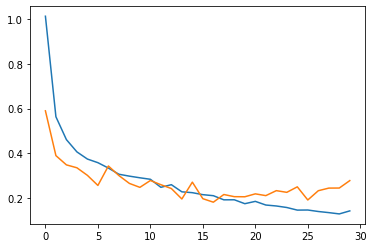

In [18]:
plt.plot(history_MC.history['loss'])
plt.plot(history_MC.history['val_loss'])
plt.show()

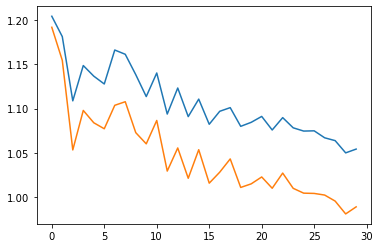

In [19]:
plt.plot(history_MC.history['val_recall_m'])
plt.plot(history_MC.history['val_f1_m'])
plt.show()

In [20]:
test_data = image_dataset_from_directory(f'{dir_data}/test_images',
                                         label_mode=None,
                                         batch_size=batch_size_MC,
                                         image_size=image_size,
                                         shuffle=False)

Found 5506 files belonging to 1 classes.


In [21]:
prediction = model_MC.predict(test_data, verbose=1)

551/551 [==============================] - 55s 95ms/step


In [22]:
preds_class = prediction.argmax(axis=-1) + 1

names_images = list((path_data / 'test_images').rglob("*.jpg"))
names_images = [path.basename(names_images[i]) for i in range(len(names_images))]

pair_pred = list(zip(names_images, preds_class))
pair_pred = pd.DataFrame(pair_pred)
pair_pred.columns = ['ImageId', 'ClassId']

In [23]:
pair_pred

,ImageId,ClassId
0,6d2a4005f.jpg,1
1,a2491cf5f.jpg,4
2,0854a9de6.jpg,3
3,6bda73259.jpg,3
4,ba8ebb757.jpg,3
...,...,...
5501,c7f574347.jpg,3
5502,815a82a36.jpg,4
5503,b7bd3555b.jpg,3
5504,b3912fc50.jpg,4


In [24]:
pair_pred.to_csv('/kaggle/working/submission.csv', index=False)

list(os.walk('/kaggle/working/'))

[('/kaggle/working/', ['.virtual_documents'], ['submission.csv']),
 ('/kaggle/working/.virtual_documents', [], [])]